In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from ipywidgets import FloatProgress
from IPython.display import display

# Setup

In [3]:
PATH = Path('../data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [4]:
trn_json = json.load((PATH/'pascal_train2007.json').open())
cats = {o['id']:o['name'] for o in trn_json['categories']}
imgs_fn = {o['id']:o['file_name'] for o in trn_json['images']}
imgs_id = [o['id'] for o in trn_json['images']]

In [5]:
trn_anno = collections.defaultdict(lambda:[])
for annot in trn_json['annotations']:
    if annot['ignore'] == 0:
        bb = annot['bbox']
        #Transforms bb which is left,top, width, height into top, left, bottom, right.
        bb = [bb[1],bb[0],bb[1] + bb[3], bb[0]+bb[2]]
        trn_anno[annot[('image_id')]].append((bb, annot['category_id']))
len(trn_anno)

2501

In [6]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
size=224
batch_size=32

In [7]:
annot_cats = [[cats[int(ann[1])] for ann in trn_anno[i]] for i in imgs_id]
id2cats = list(cats.values())
cats2id = {c:i for i,c in enumerate(id2cats)}
model_cats = np.array([np.array([cats2id[c] for c in ac]) for ac in annot_cats])
model_cats

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [8]:
val_idx = get_cv_idxs(len(imgs_id))
((val_cats, trn_cats),) = split_by_idx(val_idx, model_cats)

Bboxes

In [9]:
model_bbs = [np.concatenate([ann[0] for ann in trn_anno[i]]) for i in imgs_id]
model_bbsc = [' '.join([str(p) for p in o]) for o in model_bbs]

In [10]:
model_bbsc[:5]

['96 155 270 351',
 '61 184 199 279 77 89 336 403',
 '229 8 500 245 219 229 500 334 0 1 369 117 1 2 462 243 0 224 486 334',
 '124 89 212 337',
 '77 103 183 375 87 132 123 197 179 194 229 213 188 25 238 44']

In [11]:
trn_anno[imgs_id[2]]

[([229, 8, 500, 245], 2),
 ([219, 229, 500, 334], 2),
 ([0, 1, 369, 117], 15),
 ([1, 2, 462, 243], 15),
 ([0, 224, 486, 334], 15)]

In [12]:
df = pd.DataFrame({'fn': [imgs_fn[i] for i in imgs_id], 'bbs': model_bbsc},columns=['fn','bbs'])

In [13]:
df.head()

,fn,bbs
0,000012.jpg,96 155 270 351
1,000017.jpg,61 184 199 279 77 89 336 403
2,000023.jpg,229 8 500 245 219 229 500 334 0 1 369 117 1 2 ...
3,000026.jpg,124 89 212 337
4,000032.jpg,77 103 183 375 87 132 123 197 179 194 229 213 ...


In [14]:
df.to_csv(MBB_CSV, index=False)

In [15]:
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
           RandomLighting(0.05,0.05, tfm_y = TfmType.COORD),
           RandomFlip(tfm_y = TfmType.COORD)]
tfms = tfms_from_model(f_model, size, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y = TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idx, bs=batch_size)

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_cats)
val_ds2 = ConcatLblDataset(md.val_ds, val_cats)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

# Model and anchors 4x4

In [18]:
anc_grid = 4
k = 1 # for later
anc_offset = 1/(2*anc_grid)
anc_x = np.tile(np.linspace(anc_offset,1-anc_offset,anc_grid), anc_grid)
anc_y = np.repeat(np.linspace(anc_offset,1-anc_offset,anc_grid), anc_grid)
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid * anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [19]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [20]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

In [21]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

Activations necessary for detecting one object

In [22]:
n_clas = len(id2cats)+1

In [23]:
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k) 

In [24]:
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_in, n_clas * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(n_in, 4 * k, 3, padding = 1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [25]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.conv0 = StdConv(512,256,stride=1)
        self.conv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
    
    def forward(self,x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        x = self.conv1(x)
        return self.out(x)

Writing the loss function

In [26]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        x = preds[:,:-1]
        w = self.get_weight(x,t)# for the last part
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        return None

loss_f = BCE_Loss(len(id2cats))

In [27]:
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

In [28]:
#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs[:,:2] * grid_sizes/2) + anchors[:,:2]
    actn_hw = (1 + actn_bbs[:,2:]/2) * anchors[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cats)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,use_ab=False)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

# Influence of the initial bias

In Jeremy's notebook, the last convolutional layer that gives the categories is initiliazed with a bias of -3. When I asked him why, he explained it was because a lot of the anchors should predict the background class, so we should make it difficult for the sigmoid to be activated, hence this factor.

Let's start with the bias of -3 like in Jeremy's notebook.

In [36]:
head_reg4 = SSD_Head(k,-3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [38]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|███████████████████████████████████████████████████████▎           | 52/63 [00:31<00:06,  1.66it/s, loss=1.31e+03]

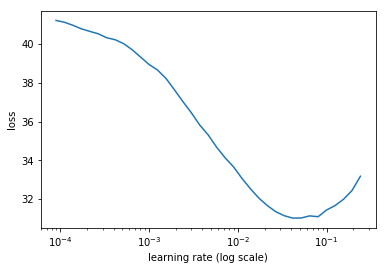

In [39]:
learn.sched.plot()

In [40]:
lr = 1e-2

In [54]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      20.929501  18.910183 
    1      17.86262   16.488575                                                                                        
    2      16.310839  15.498018                                                                                        
    3      15.109892  15.010017                                                                                        
    4      14.098554  14.523777                                                                                        



[14.523777]

Now let's fo the same thing without initializing the bias at -3.

In [55]:
learn.save('bias-3')

In [42]:
head_reg4 = SSD_Head(k,0.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [43]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|██████████████████████████████████████████████████████████████▊         | 55/63 [00:30<00:04,  1.82it/s, loss=972]

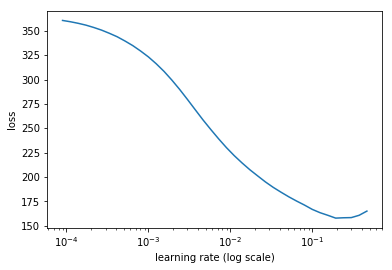

In [44]:
learn.sched.plot()

Even if the loss is way bigger at the beginning, it doesn't seem to change the learning rate, so let's try to fit.

In [45]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  6%|████▋                                                                    | 4/63 [00:03<00:52,  1.12it/s, loss=326]


Exception in thread Thread-14:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      40.370653  21.679268 
    1      24.413239  18.400091                                                                                        
    2      19.805302  17.092875                                                                                        
    3      17.59664   16.168324                                                                                        
    4      16.291103  15.369914                                                                                        



[15.369914]

In [46]:
learn.save('bias0')

The loss is indeed worse. Now let's even try to do the opposite and initialize the bias at +3

In [47]:
head_reg4 = SSD_Head(k,3)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [48]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████████████████████████████████████████████████████████▋     | 58/63 [00:31<00:02,  1.87it/s, loss=2.84e+03]

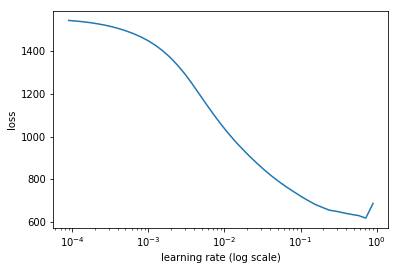

In [49]:
learn.sched.plot()

It looks like this time we can pick a higher learning rate. The loss at the beginning is also way higher than before!

In [51]:
learn.fit(5*lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]


Exception in thread Thread-20:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      87.238823  26.501392 
    1      36.56298   19.266548                                                                                        
    2      24.075832  31.767622                                                                                        
    3      20.066492  31.117821                                                                                        
    4      18.413494  16.906162                                                                                        



[16.906162]

In [52]:
learn.save('bias3')

Again, the loss is worse than before. There's really an interest in initializing the bias woith a negative value. Now let's see what those bias look like when the training is finished.

In [57]:
learn.load('bias-3')

In [67]:
outConv1 = learn.model[8].out.oconv1

In [69]:
outConv1.bias.mean()

Variable containing:
-3.0918
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [71]:
learn.load('bias0')

In [74]:
outConv1 = learn.model[8].out.oconv1
outConv1.bias.mean()

Variable containing:
1.00000e-02 *
 -6.3792
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [75]:
learn.load('bias3')

In [76]:
outConv1 = learn.model[8].out.oconv1
outConv1.bias.mean()

Variable containing:
 2.7783
[torch.cuda.FloatTensor of size 1 (GPU 0)]

This is very surprising (for me). I would have thought that the model would have learned to put a negative bias, since it seems to make it easier for him, but he didn't do that. The bias have barely changed from their initial values. 

Now let's see if we can manage the same error without bias as when we initialized with -3, just by training longer.

In [77]:
learn.load('bias0')

In [78]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      18.60108   17.518761 
    1      17.316723  16.283512                                                                                        
    2      16.029754  17.229944                                                                                        
    3      14.924728  15.018361                                                                                        
    4      14.035353  14.558006                                                                                        



[14.558006]

Even with a second cycle we're still not as good as the model with bias initialized at -3

In [79]:
head_reg4 = SSD_Head(k,0)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [80]:
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      42.762562  21.587082 
    1      24.99543   19.196276                                                                                        
    2      20.081579  17.913952                                                                                        
    3      18.114532  16.890486                                                                                        
    4      16.93616   16.752743                                                                                        
    5      15.928686  16.028091                                                                                        
    6      15.101899  15.778208                                                                                        
    7      14.549666  16.048922                                                                                        
    8  

[15.014502]

Doing a longer cycle doesn't help either.

What about even stronger negative bias?

In [135]:
head_reg4 = SSD_Head(k,-6)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [83]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|█████████████████████████████████████████████████████████▏              | 50/63 [00:27<00:07,  1.83it/s, loss=181]

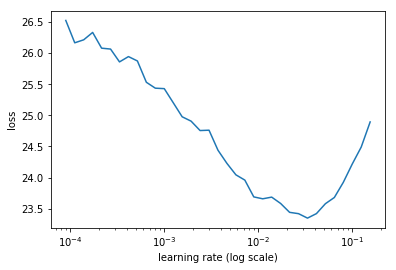

In [84]:
learn.sched.plot()

The beginning loss is even lower than when we initialized at -3. It also looks like we need to pick a lower learning rate.

In [87]:
learn.fit(lr/2, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      19.360822  17.005886 
    1      17.448353  15.66676                                                                                         
    2      16.08572   15.372393                                                                                        
    3      14.983382  14.701052                                                                                        
    4      14.041856  14.399405                                                                                        



[14.399405]

And indeed our final result is slightly better.

In [89]:
learn.save('bias-6')

In [90]:
outConv1 = learn.model[8].out.oconv1
outConv1.bias.mean()

Variable containing:
-6.0423
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Again, the values of our bias have barely changed.

So an initial negative bias seem to help a lot. How do we pick a good value? Looking at all the plots from our learning rate finder, I had the idea to try to find a value that minimizes the initial loss. The function below computes the loss for the first training mini-batch with bias ranging from -10 to 0.

In [194]:
def test_loss(min_b=-10,max_b=0,n=100):
    test_biases = np.linspace(min_b,max_b,n)
    losses = np.zeros(n)
    x,y=next(iter(md.trn_dl))
    x,y = V(x),V(y)
    nb = learn.model[8].out.oconv1.bias.size(0)
    fp = FloatProgress(min=0,max=n)
    display(fp)
    for i in range(n):
        learn.model[8].out.oconv1.bias = torch.nn.Parameter(torch.Tensor([test_biases[i]]*nb).cuda())
        z = learn.model(x)
        losses[i] = ssd_loss(z,y)
        fp.value += 1
    return test_biases,losses

In [195]:
head_reg4 = SSD_Head(k,0)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [196]:
b,l = test_loss()

FloatProgress(value=0.0)

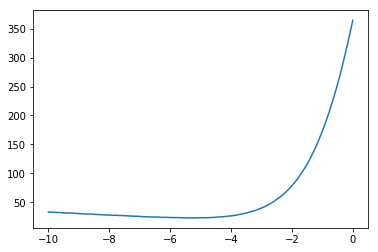

In [151]:
plt.plot(b,l)
plt.show()

We can see on the plot that 0 is really  bad value compared to -3 or -6. Then it seem those give the same range of loss. Now let's pick the bias giving the minimum loss.

In [152]:
b[l.argmin()]

-5.454545454545455

In [159]:
head_reg4 = SSD_Head(k,-5.45)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [154]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|█████████████████████████████████████████████████████████▏              | 50/63 [00:28<00:07,  1.78it/s, loss=107]

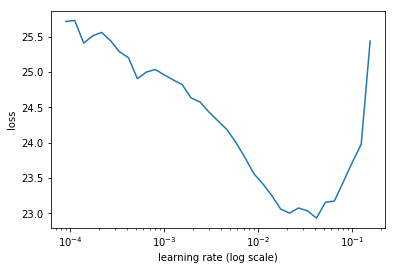

In [155]:
learn.sched.plot()

In [160]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      19.675239  18.063049 
    1      17.461465  16.142759                                                                                        
    2      16.149953  15.330717                                                                                        
    3      15.024208  14.744383                                                                                        
    4      14.235962  14.417577                                                                                        



[14.417577]

In the same ballpark as -6, which was expected, but not as good.

The next thing I tried was to compute the loss over the entire validation set, and not just a mini-batch, and find the bias that minimizes it.

In [200]:
def test_loss1(min_b=-10,max_b=0, n=50):
    test_biases = np.linspace(min_b,max_b,n)
    losses = np.zeros(n)
    nb = learn.model[8].out.oconv1.bias.size(0)
    fp = FloatProgress(min=0,max=n)
    display(fp)
    for i in range(n):
        learn.model[8].out.oconv1.bias = torch.nn.Parameter(torch.Tensor([test_biases[i]]*nb).cuda())
        for data in md.val_dl:
            x,y=data
            x,y = V(x),V(y)
            z = learn.model(x)
            losses[i] += ssd_loss(z,y)
        fp.value+=1
    return test_biases,losses

In [201]:
head_reg4 = SSD_Head(k,0)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)

It takes longer to run, so let's focus near the values we know are good.

In [202]:
b1,l1 = test_loss1(-7,-4,20)

FloatProgress(value=0.0, max=20.0)

-5.105263157894737

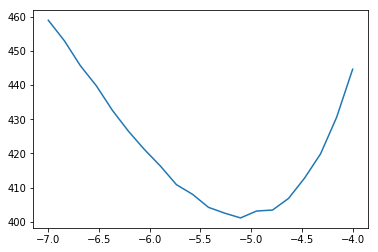

In [203]:
plt.plot(b1,l1)
b1[(l1).argmin()]

The minimum is slightly different, and just for the sake of it, let's try with this value.

In [205]:
head_reg4 = SSD_Head(k,-5.1)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [190]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|█████████████████████████████████████████████████████████▏              | 50/63 [00:30<00:07,  1.65it/s, loss=105]

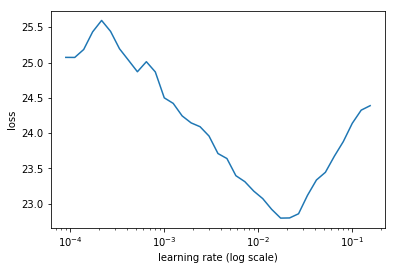

In [191]:
learn.sched.plot()

In [207]:
learn.fit(lr/2, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      17.576413  17.692612 
    1      16.528931  15.526525                                                                                        
    2      15.34304   14.95686                                                                                         
    3      14.329203  14.645228                                                                                        
    4      13.364364  14.448114                                                                                        



[14.448114]

A bit less good than -6, but still in the same range.

As of now, the best results we have had were with a bias of -6 but perhaps we should have take one even lower, since the one that minimizes the initial loss doesn't seem to be the best choice.

In [31]:
head_reg4 = SSD_Head(k,-8)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [32]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 14%|██████████▎                                                             | 9/63 [00:06<00:40,  1.33it/s, loss=33.2]


Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 79%|█████████████████████████████████████████████████████████▏              | 50/63 [00:29<00:07,  1.69it/s, loss=128]


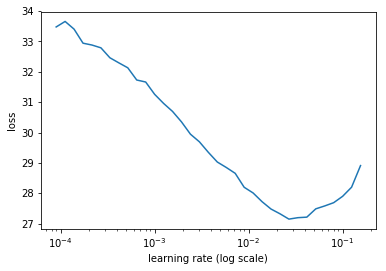

In [34]:
learn.sched.plot()

In [35]:
lr = 1e-2
learn.fit(lr/2, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      20.074092  17.688038 
    1      17.585098  16.027065                                                                                        
    2      16.097799  15.334451                                                                                        
    3      15.018225  14.841715                                                                                        
    4      14.134768  14.573221                                                                                        



[14.573221]

It's not as good. So the best value seems to be close to the minimum we computed, and we can stick with that approach to pick the way to initalize the bias.

# Model with more anchors

In [29]:
anc_grids = [4,2,1]
# anc_grids = [4]
anc_zooms = [0.75, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

In [30]:
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [31]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [32]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, dp=drop)
        self.sconv2 = StdConv(256,256, dp=drop)
        self.sconv3 = StdConv(256,256, dp=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cats))

In [33]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

Now let's do the same thing with the model having multiple anchors. We just have to change the bias on three different layers (the ones giving the ouputs of grid sizes 1, 2 and 4).

In [34]:
def test_loss(min_b=-10,max_b=0,n=100):
    test_biases = np.linspace(min_b,max_b,n)
    losses = np.zeros(n)
    x,y=next(iter(md.trn_dl))
    x,y = V(x),V(y)
    nb1 = learn.model[8].out1.oconv1.bias.size(0)
    nb2 = learn.model[8].out2.oconv1.bias.size(0)
    nb3 = learn.model[8].out3.oconv1.bias.size(0)
    fp = FloatProgress(min=0,max=n)
    display(fp)
    for i in range(n):
        learn.model[8].out1.oconv1.bias = torch.nn.Parameter(torch.Tensor([test_biases[i]]*nb1).cuda())
        learn.model[8].out2.oconv1.bias = torch.nn.Parameter(torch.Tensor([test_biases[i]]*nb2).cuda())     
        learn.model[8].out3.oconv1.bias = torch.nn.Parameter(torch.Tensor([test_biases[i]]*nb3).cuda())
        z = learn.model(x)
        losses[i] = ssd_loss(z,y)
        fp.value += 1
    return test_biases,losses

In [222]:
b,l = test_loss()

FloatProgress(value=0.0)

-3.0303030303030303

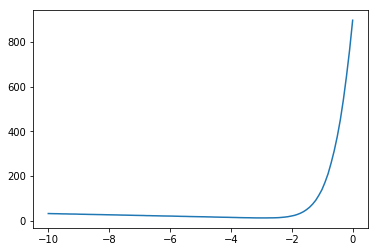

In [224]:
plt.plot(b,l)
b[l.argmin()]

Looks like here -3 is the minimum.

In [236]:
head_reg4 = SSD_MultiHead(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [227]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|████████████████████████████████████████████████████▉                  | 47/63 [00:29<00:10,  1.60it/s, loss=51.8]

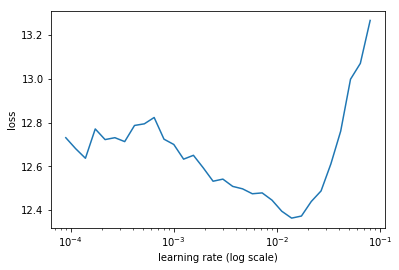

In [228]:
learn.sched.plot()

In [237]:
lr=5e-3
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      10.323396  9.283987  
    1      9.148537   7.844613                                                                                         
    2      8.142496   7.123969                                                                                         
    3      7.453313   6.933463                                                                                         
    4      6.891545   6.666717                                                                                         
    5      6.49946    6.372166                                                                                         
    6      6.170587   6.328063                                                                                         
    7      5.906324   6.163712                                                                                         
    8  

[6.0198355]

In [238]:
learn.save('focus-3')

Now Jeremy had picked -4 in his notebook, so let's compare the results.

In [ ]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [232]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████████████████████████████████████████████████████▏               | 49/63 [00:31<00:08,  1.56it/s, loss=91.2]

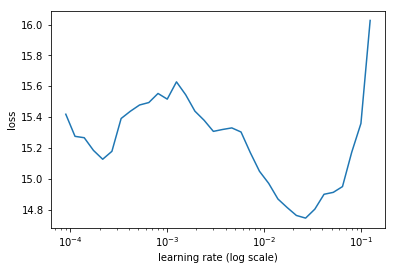

In [233]:
learn.sched.plot()

In [234]:
lr=1e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 19%|█████████████▌                                                         | 12/63 [00:09<00:40,  1.26it/s, loss=15.8]


Exception in thread Thread-110:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      11.619312  11.035986 
    1      9.885275   8.210117                                                                                         
    2      8.456624   7.359024                                                                                         
    3      7.573123   7.21607                                                                                          
    4      7.018994   6.589329                                                                                         
    5      6.573195   6.489747                                                                                         
    6      6.310443   6.318949                                                                                         
    7      6.093323   6.214604                                                                                         
    8  

[6.0284758]

In [235]:
learn.save('focus-4')

Very similar end losses. Now let's see how the model does when we continue the training.

In [40]:
learn.load('focus-3')
learn.freeze_to(-2)
lr = 5e-3
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      5.627191   6.129256  
    1      5.584963   6.024652                                                                                         
    2      5.440576   5.920463                                                                                         
    3      5.14999    5.875351                                                                                         
    4      4.975074   5.703865                                                                                         
    5      4.830699   5.639754                                                                                         
    6      4.642337   5.639698                                                                                         
    7      4.533329   5.578117                                                                                         
    8  

[5.523815]

In [41]:
learn.save('focus-3b')

In [42]:
learn.load('focus-4')
learn.freeze_to(-2)
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      5.906129   6.460793  
    1      5.921797   6.342263                                                                                         
    2      5.696199   6.043509                                                                                         
    3      5.522027   5.826624                                                                                         
    4      5.271962   5.80883                                                                                          
    5      5.031068   5.731424                                                                                         
    6      4.808868   5.759064                                                                                         
    7      4.635631   5.612777                                                                                         
    8  

[5.4974074]

In [43]:
learn.save('focus-4b')

Again similar performances.

What if we hadn't done anything? Would a model have caught up with enough training?

In [46]:
head_reg4 = SSD_MultiHead(k, 0)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [47]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████████████████████████████████████████████████████████▋     | 58/63 [00:34<00:02,  1.67it/s, loss=1.61e+03]

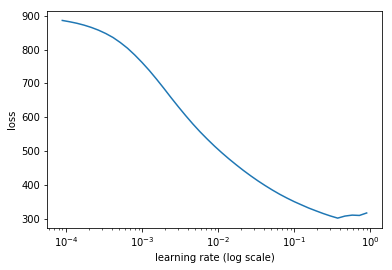

In [48]:
learn.sched.plot()

In [49]:
lr=5e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 16%|███████████▍                                                            | 10/63 [00:08<00:43,  1.22it/s, loss=249]


Exception in thread Thread-41:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      40.559813  16.122211 
    1      18.568694  11.207973                                                                                        
    2      12.854556  10.102815                                                                                        
    3      11.269436  10.136271                                                                                        
    4      10.409943  9.105105                                                                                         
    5      9.72097    9.010611                                                                                         
    6      9.236041   8.544959                                                                                         
    7      8.82257    8.325523                                                                                         
    8  

[7.663162]

In [50]:
learn.save('focus0')

In [52]:
learn.load('focus0')
learn.freeze_to(-2)
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  8%|█████▋                                                                  | 5/63 [00:05<01:08,  1.18s/it, loss=7.64]


Exception in thread Thread-52:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  8%|█████▋                                                                  | 5/63 [00:06<01:19,  1.38s/it, loss=7.64]

epoch      trn_loss   val_loss                                                                                         
    0      7.910938   137.57576 
    1      7.743102   7.533659                                                                                         
    2      7.425774   7.014266                                                                                         
    3      7.093451   7.022715                                                                                         
    4      6.826189   6.793766                                                                                         
    5      6.703976   6.662138                                                                                         
    6      6.430899   6.531081                                                                                         
    7      6.197219   6.442986                                                                                         
    8  

[6.3064485]

In [53]:
learn.save('focus0b')

We aren't even at the point we reached in just one cycle with -3 or -4 bias, so there's a clear interest in initializing them like this!